# Feature Extraction and Image Processing
Mark S. Nixon & Alberto S. Aguado http://www.southampton.ac.uk/~msn/book/
### Chapter 4: *ColourImageSegmentation*
Colour image segmentation by using UNet model
***  

### Setup modules

In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), "../../Modules"))

# Tensor flow
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy

# For create image array
import numpy as np 

# For loading data
import pickle

# Module functions
from ImageUtilities import imageReadRGBF, plotImageRGBF
from PlotUtilities import plot2Curves

### Parameters
    pathToDir = Directory to store data
    dataSetFileName = Name of the data file
    modelFileName = Name of the file to save the trained model

In [2]:
pathToDir = os.path.join(os.path.dirname("__file__"), "../../Images/Chapter4/Input/")
dataSetFileName = "PetSegmentationData.pickle"
modelFileName = "ColourSegmentationModel.keras"

### Read and show image data

(3000, 128, 128, 3) (3000, 128, 128, 1) (300, 128, 128, 3) (300, 128, 128, 1)
(128, 128, 3) (128, 128, 1) (128, 128, 3) (128, 128, 1)


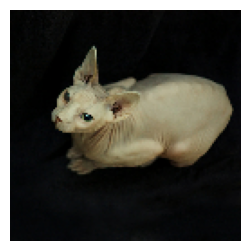

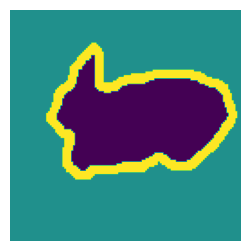

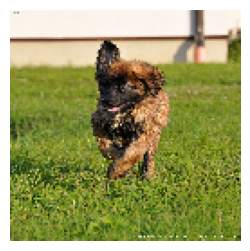

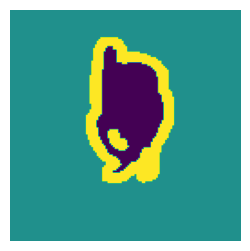

In [3]:
with open(pathToDir+dataSetFileName, 'rb') as f:
     data = pickle.load(f)

trainImages, trainMasks, testImages, testMasks = data 

print(trainImages.shape, trainMasks.shape, testImages.shape, testMasks.shape)
print(trainImages[0].shape, trainMasks[0].shape, testImages[0].shape, testMasks[0].shape)

plotImageRGBF(trainImages[0], 3)
plotImageRGBF(trainMasks[0], 3)

plotImageRGBF(testImages[0], 3)
plotImageRGBF(testMasks[0], 3)

### Functions to create the model

In [4]:
# Create convolution layers
def creareConvolutionLayers(input, numFilters, kernelSize = 3):
   
    convlolutionLayer = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),\
            kernel_initializer = 'he_normal', padding = 'same', activation='relu')(input)
    
    convlolutionLayer = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),\
            kernel_initializer = 'he_normal', padding = 'same', activation='relu')(convlolutionLayer)    
    return convlolutionLayer

# Encoder 
def encoder(inputs):

  # Convolution block and pool and drop
  convolutionFeatures1 = creareConvolutionLayers(inputs, numFilters = 64, kernelSize=3)
  maxPool = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(convolutionFeatures1)
  dropOut = tf.keras.layers.Dropout(0.3)(maxPool)

  # Convolution block and pool and drop
  convolutionFeatures2 = creareConvolutionLayers(dropOut, numFilters = 128, kernelSize=3)
  maxPool = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(convolutionFeatures2)
  dropOut = tf.keras.layers.Dropout(0.3)(maxPool)

  # Convolution block and pool and drop
  convolutionFeatures3 = creareConvolutionLayers(dropOut, numFilters = 256, kernelSize=3)
  maxPool = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(convolutionFeatures3)
  dropOut = tf.keras.layers.Dropout(0.3)(maxPool)

  # Convolution block and pool and drop
  convolutionFeatures4 = creareConvolutionLayers(dropOut, numFilters = 512, kernelSize=3)
  maxPool = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(convolutionFeatures4)
  dropOut = tf.keras.layers.Dropout(0.3)(maxPool)

  return dropOut, (convolutionFeatures1, convolutionFeatures2, convolutionFeatures3, convolutionFeatures4)

# Botleneck
def bottleneck(inputs):

  convolutionFeatures = creareConvolutionLayers(inputs, 1024, 3)
  return convolutionFeatures

# Decoder 
def decoder(inputs, convolutionLayers, numOutputChannels):
 
  convolutionFeatures1, convolutionFeatures2, convolutionFeatures3, convolutionFeatures4 = convolutionLayers

  transpose = tf.keras.layers.Conv2DTranspose(128, kernel_size = (3,3), strides = (2,2), padding = 'same')(inputs)
  concatenate = tf.keras.layers.concatenate([transpose, convolutionFeatures4])
  dropOut = tf.keras.layers.Dropout(0.3)(concatenate)
  convolution = creareConvolutionLayers(dropOut, numFilters = 128, kernelSize=3)

  transpose = tf.keras.layers.Conv2DTranspose(256, kernel_size = (3,3), strides = (2,2), padding = 'same')(convolution)
  concatenate = tf.keras.layers.concatenate([transpose, convolutionFeatures3])
  dropOut = tf.keras.layers.Dropout(0.3)(concatenate)
  convolution = creareConvolutionLayers(dropOut, numFilters = 256, kernelSize=3)

  transpose = tf.keras.layers.Conv2DTranspose(128, kernel_size = (3,3), strides = (2,2), padding = 'same')(convolution)
  concatenate = tf.keras.layers.concatenate([transpose, convolutionFeatures2])
  dropOut = tf.keras.layers.Dropout(0.3)(concatenate)
  convolution = creareConvolutionLayers(dropOut, numFilters = 128, kernelSize=3)

  transpose = tf.keras.layers.Conv2DTranspose(64, kernel_size = (3,3), strides = (2,2), padding = 'same')(convolution)
  concatenate = tf.keras.layers.concatenate([transpose, convolutionFeatures1])
  dropOut = tf.keras.layers.Dropout(0.3)(concatenate)
  convolution = creareConvolutionLayers(dropOut, numFilters = 64, kernelSize=3)

  outputs = tf.keras.layers.Conv2D(numOutputChannels, kernel_size = (1, 1), activation='softmax')(convolution)

  return outputs

### Create model

In [5]:
# Three classes segmentation
outputDimensions = 3

# Size of the images
imageSize = trainImages.shape[1]

# Input definition. Thhree values per pixel
inputs = tf.keras.layers.Input(shape=(imageSize, imageSize,3,))

# Encoder
encoderOutput, convolutionLayers = encoder(inputs)

# Bottleneck
bottleNeckOutput = bottleneck(encoderOutput)

# Decoder
decoderOutput = decoder(bottleNeckOutput, convolutionLayers, numOutputChannels=outputDimensions)

# create the model
model = tf.keras.Model(inputs, decoderOutput)

# see the resulting model architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 128, 128, 64)      │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 128, 128, 64)      │          36,928 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 64, 64)        │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 64, 64, 64)        │               0 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 64, 64, 128)       │          73,856 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 64, 64, 128)       │         147,584 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 32, 128)       │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 32, 32, 128)       │               0 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 32, 32, 256)       │         295,168 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 32, 32, 256)       │         590,080 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 16, 16, 256)       │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 16, 16, 256)       │               0 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 16, 16, 512)       │       1,180,160 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 16, 16, 512)       │       2,359,808 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 8, 8, 512)         │               0 │ conv2d_7[0][0]             │
│ (MaxPooling2D)                │                           │               

 Total params: 23,895,491 (91.15 MB)

 Trainable params: 23,895,491 (91.15 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [6]:
print(trainImages.shape)
print(trainMasks.shape)
print(testImages.shape)
print(testMasks.shape)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# configure the training parameters and train the model
history = model.fit(trainImages, trainMasks, epochs=10)

(3000, 128, 128, 3)
(3000, 128, 128, 1)
(300, 128, 128, 3)
(300, 128, 128, 1)
Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 342s 4s/step - accuracy: 0.5569 - loss: 1.0248
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 342s 4s/step - accuracy: 0.7136 - loss: 0.7182
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 342s 4s/step - accuracy: 0.7527 - loss: 0.6140
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 344s 4s/step - accuracy: 0.7796 - loss: 0.5591
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 349s 4s/step - accuracy: 0.8048 - loss: 0.5006
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 350s 4s/step - accuracy: 0.8217 - loss: 0.4591
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 349s 4s/step - accuracy: 0.8296 - loss: 0.4408
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 351s 4s/step - accuracy: 0.8361 - loss: 0.4231
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 353s 4s/step - accuracy: 0.8430 - loss: 0.4065
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 352s 4s/step - accuracy: 0.8532 - loss: 0.3841


### Plot training

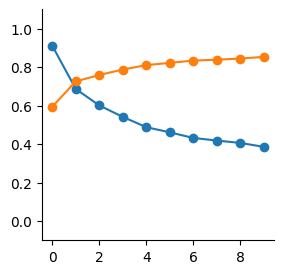

In [7]:
plot2Curves(history.history['loss'], history.history['accuracy'], rangeY = [-.1, 1.1])

### Save model

In [8]:
model.save(pathToDir+modelFileName)

### Load model

In [9]:
model = tf.keras.models.load_model(pathToDir+modelFileName)

# Show the model architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 128, 128, 64)      │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 128, 128, 64)      │          36,928 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 64, 64)        │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 64, 64, 64)        │               0 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 64, 64, 128)       │          73,856 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 64, 64, 128)       │         147,584 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 32, 128)       │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 32, 32, 128)       │               0 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 32, 32, 256)       │         295,168 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 32, 32, 256)       │         590,080 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 16, 16, 256)       │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 16, 16, 256)       │               0 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 16, 16, 512)       │       1,180,160 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 16, 16, 512)       │       2,359,808 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 8, 8, 512)         │               0 │ conv2d_7[0][0]             │
│ (MaxPooling2D)                │                           │               

 Total params: 71,686,475 (273.46 MB)

 Trainable params: 23,895,491 (91.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,790,984 (182.31 MB)

### Evaluation

In [10]:
test_loss, test_acc = model.evaluate(testImages, testMasks)
print("accuracy:", test_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 968ms/step - accuracy: 0.8512 - loss: 0.4048
accuracy: 0.8484507203102112


### Prediction

10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 990ms/step
[8.8903568e-07 9.9987209e-01 1.2699084e-04]


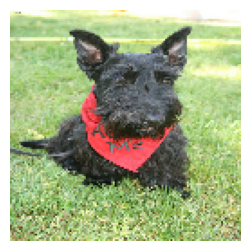

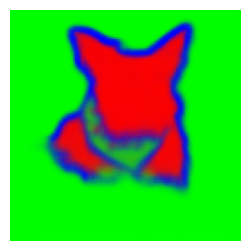

In [11]:
imageToPredict = 27

predictions=model.predict(testImages)

print(predictions[imageToPredict][3][3])

plotImageRGBF(testImages[imageToPredict], 3)
plotImageRGBF(predictions[imageToPredict], 3)


### Predict for new image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


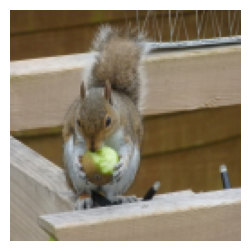

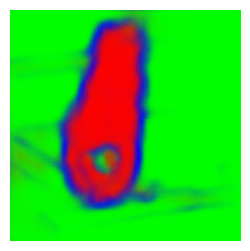

In [12]:
# Read image
imageName = "Squirrel.png"
pathToDir = os.path.join(os.path.dirname("__file__"), "../../Images/Chapter4/Input/")
inputImage, width, height  = imageReadRGBF(pathToDir + imageName)

# Prediction
testmagesN = np.array( [inputImage])
predictions=model.predict(testmagesN)

# Show results
plotImageRGBF(inputImage, 3)
plotImageRGBF(predictions[0], 3)
